<a href="https://colab.research.google.com/github/psedocode01/Final-Team10/blob/main/%ED%8C%8C%EC%9D%B4%EB%84%90_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_9%EC%9B%94_18%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

In [ ]:
DATA_PATH = "movies_ratings_post2020.csv"
df = pd.read_csv(DATA_PATH)

### 데이터 로딩 및 기본 전처리

In [ ]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df = pd.read_csv("movies_ratings_post2020.csv")

# 개봉연도 추출
df["release_year"] = df["title"].str.extract(r"\((\d{4})\)").astype(float)

# timestamp → datetime
df["rating_dt"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")
df["rating_year"] = df["rating_dt"].dt.year

# 개봉 후 경과 시간
df["age_at_rating"] = df["rating_year"] - df["release_year"]
df = df[(df["age_at_rating"] >= 0) & df["age_at_rating"].notna()]


### 장르 필터링

In [ ]:
# 분석할 장르
target_genres = ["Drama", "Action", "Comedy", "Thriller", "Adventure", "Sci-Fi", "Crime"]

# 예: Drama 필터링
genre = "Drama"
sub = df[df["genres"].str.contains(genre, na=False)].copy()
print(f"{genre} 데이터 건수:", len(sub))


Drama 데이터 건수: 72043


### 영화별 평점 분산 + 구간화

In [ ]:
# 영화별 평점 분산
movie_var = sub.groupby("movieId")["rating"].var().reset_index().rename(columns={"rating":"var"})

# 영화 정보 붙이기
movie_var = movie_var.merge(sub[["movieId","age_at_rating"]], on="movieId", how="left").drop_duplicates("movieId")

# 경과시간 구간 (5년 단위)
movie_var["age_bin"] = pd.cut(movie_var["age_at_rating"], bins=np.arange(0, 85, 5))

# 구간별 평균 분산
age_var = movie_var.groupby("age_bin")["var"].mean().reset_index()
print(age_var.head())


    age_bin       var
0    (0, 5]  0.850058
1   (5, 10]  0.913278
2  (10, 15]  0.931576
3  (15, 20]  0.929664
4  (20, 25]  0.870292


/tmp/ipython-input-1616509487.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = movie_var.groupby("age_bin")["var"].mean().reset_index()


### 시각화

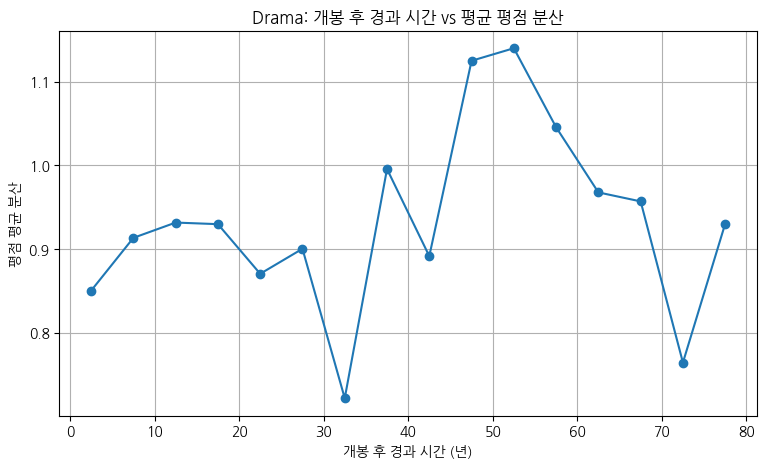

In [ ]:
import matplotlib.pyplot as plt

age_var["age_mid"] = age_var["age_bin"].apply(lambda x: (x.left + x.right)/2)

plt.figure(figsize=(9,5))
plt.plot(age_var["age_mid"], age_var["var"], marker="o")
plt.title(f"{genre}: 개봉 후 경과 시간 vs 평균 평점 분산")
plt.xlabel("개봉 후 경과 시간 (년)")
plt.ylabel("평점 평균 분산")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# 1) 데이터 불러오기
df = pd.read_csv("movies_ratings_post2020.csv")

# 2) 개봉연도
df["release_year"] = df["title"].str.extract(r"\((\d{4})\)").astype(float)

# 3) rating 시점
df["rating_dt"]   = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")
df["rating_year"] = df["rating_dt"].dt.year

# 4) 개봉 후 경과 시간(년)
df["age_at_rating"] = df["rating_year"] - df["release_year"]
df = df[(df["age_at_rating"] >= 0) & df["age_at_rating"].notna()].copy()
print(df.shape, df.columns[:10])


(164508, 11) Index(['userId', 'movieId', 'rating', 'timestamp', 'rating_dt', 'rating_year',
       'title', 'genres', 'year', 'release_year'],
      dtype='object')


In [ ]:
# 장르 문자열을 분해하여 개수 집계
genres_long = (
    df.assign(genre_list=df["genres"].fillna("").astype(str).str.split("|"))
      .explode("genre_list")
)
genre_counts = (genres_long[genres_long["genre_list"] != ""]
                .groupby("genre_list")["movieId"].count()
                .sort_values(ascending=False))
top6_genres = genre_counts.index[:6].tolist()
print("Top-6 genres:", top6_genres)


Top-6 genres: ['Drama', 'Action', 'Comedy', 'Thriller', 'Adventure', 'Sci-Fi']


In [ ]:
def make_age_variance_table(df, genre, bins=np.arange(0, 85, 5), min_ratings_per_movie=2):
    # 장르 필터링
    sub = df[df["genres"].str.contains(genre, na=False)].copy()
    if sub.empty:
        return None

    # 영화별 리뷰 수 필터(분산 가능하도록)
    movie_n = sub.groupby("movieId")["rating"].transform("count")
    sub = sub[movie_n >= min_ratings_per_movie].copy()
    if sub.empty:
        return None

    # 영화별 평점 분산(코로나 이후 평점 기준)
    movie_var = (sub.groupby("movieId")["rating"].var()
                    .reset_index().rename(columns={"rating":"var"}))

    # 영화별 대표 경과시간(평균) 부여
    movie_age = sub.groupby("movieId")["age_at_rating"].mean().reset_index()
    movie_var = movie_var.merge(movie_age, on="movieId", how="left")

    # 경과시간 구간화 → 구간별 평균 분산
    movie_var["age_bin"] = pd.cut(movie_var["age_at_rating"], bins=bins)
    age_var = (movie_var.groupby("age_bin")["var"].mean()
                         .reset_index().dropna(subset=["age_bin"]))
    if age_var.empty:
        return None

    # 구간 중앙값(시각화 x축)
    age_var["age_mid"] = age_var["age_bin"].apply(lambda iv: (iv.left + iv.right)/2)
    return age_var


/tmp/ipython-input-502790064.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = (movie_var.groupby("age_bin")["var"].mean()
/tmp/ipython-input-502790064.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = (movie_var.groupby("age_bin")["var"].mean()
/tmp/ipython-input-502790064.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = (movie_var.groupby("age_bin")["var"].mean()
/tmp/ipython-inp

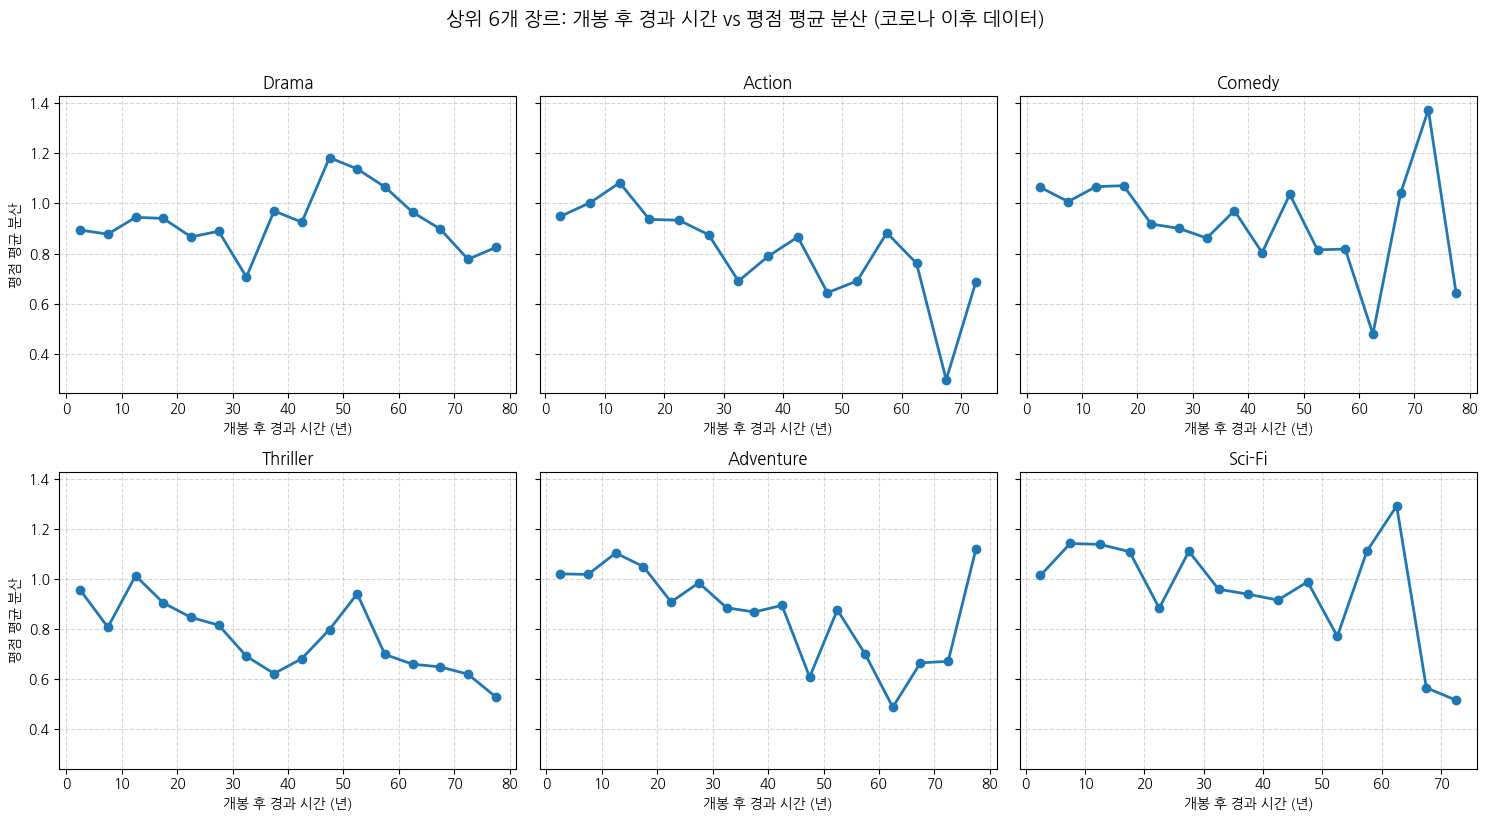

KeyError: 'genre'

In [ ]:
import matplotlib.pyplot as plt

bins = np.arange(0, 85, 5)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.ravel()

summary_rows = []

for i, g in enumerate(top6_genres):
    ax = axes[i]
    age_var = make_age_variance_table(df, g, bins=bins, min_ratings_per_movie=2)
    if (age_var is None) or (len(age_var) < 2):
        ax.set_title(f"{g} (데이터 부족)")
        ax.axis("off")
        summary_rows.append({"genre": g, "note": "insufficient data"})
        continue

    # 선 그래프
    ax.plot(age_var["age_mid"], age_var["var"], marker="o", linewidth=2)
    ax.set_title(g)
    ax.set_xlabel("개봉 후 경과 시간 (년)")
    if i % 3 == 0:
        ax.set_ylabel("평점 평균 분산")
    ax.grid(True, linestyle="--", alpha=0.5)


# 빈 축 끄기(상위 장르가 6개 미만일 경우 대비)
for j in range(len(top6_genres), 6):
    axes[j].axis("off")

plt.suptitle("상위 6개 장르: 개봉 후 경과 시간 vs 평점 평균 분산 (코로나 이후 데이터)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(summary_rows)
print(summary_df.sort_values("genre"))


### 1. 데이터 로드 + 기본 전처리

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("movies_ratings_post2020.csv")

# rating 시점 파생
df["rating_dt"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")
df["rating_year"] = df["rating_dt"].dt.year

# 개봉연도: title(1994)에서 추출, 없으면 year 컬럼 사용
df["release_year"] = df["title"].str.extract(r"\((\d{4})\)").astype(float)
if "year" in df.columns:
    df["release_year"] = df["release_year"].fillna(df["year"])

print("cols:", df.columns.tolist())
print(df.head(3))

cols: ['userId', 'movieId', 'rating', 'timestamp', 'rating_dt', 'rating_year', 'title', 'genres', 'year', 'release_year']
   userId  movieId  rating   timestamp           rating_dt  rating_year  \
0      22      316     3.0  1614575253 2021-03-01 05:07:33         2021   
1      22      471     4.0  1583618543 2020-03-07 22:02:23         2020   
2      22      551     4.0  1583618449 2020-03-07 22:00:49         2020   

                                    title                              genres  \
0                         Stargate (1994)             Action|Adventure|Sci-Fi   
1             Hudsucker Proxy, The (1994)                              Comedy   
2  Nightmare Before Christmas, The (1993)  Animation|Children|Fantasy|Musical   

     year  release_year  
0  1994.0        1994.0  
1  1994.0        1994.0  
2  1993.0        1993.0  


### 2. 영화별 리뷰 수 만들기

In [ ]:
# 영화별 리뷰 수 계산
rating_counts = (df.groupby("movieId")["rating"]
                   .count()
                   .reset_index()
                   .rename(columns={"rating":"vote_count"}))

# 원본에 merge
df = df.merge(rating_counts, on="movieId", how="left")
print(df[["movieId","title","vote_count"]].head())


   movieId                                   title  vote_count
0      316                         Stargate (1994)          45
1      471             Hudsucker Proxy, The (1994)          16
2      551  Nightmare Before Christmas, The (1993)          64
3      745  Wallace & Gromit: A Close Shave (1995)          22
4     1036                         Die Hard (1988)         187


### 3. 중앙값 기준 인기 영화 필터링

중앙값(median) → 분포의 왜곡(몇몇 초대형 인기작)이 큰 경우 더 타당함.
예: 영화별 평점 수가 200개 이상(중앙값) → 포함.

Baseline: 중앙값 기준 (예: 영화별 리뷰 수 ≥ median)

In [ ]:
# 중앙값(메디안) 기준으로 인기작 정의
median_votes = df["vote_count"].median()
popular = df[df["vote_count"] >= median_votes].copy()

print(f"전체 행 수: {len(df):,}")
print(f"중앙값 기준 vote_count >= {int(median_votes)} 인 행 수: {len(popular):,}")
print(f"영화 수(중복 제거): 전체 {df['movieId'].nunique():,} → 인기 {popular['movieId'].nunique():,}")


전체 행 수: 165,302
중앙값 기준 vote_count >= 58 인 행 수: 83,243
영화 수(중복 제거): 전체 17,940 → 인기 619


### 4. 개봉 후 경과 시간 구간화

In [ ]:
# 경과 시간(년): 리뷰가 남겨진 '그 시점' 기준
popular["age_at_rating"] = popular["rating_year"] - popular["release_year"]
popular = popular[np.isfinite(popular["age_at_rating"]) & (popular["age_at_rating"] >= 0)].copy()

# 5년 단위 bin
bins = np.arange(0, popular["age_at_rating"].max() + 5, 5)
labels = [f"{int(b)}~{int(b+5)}년" for b in bins[:-1]]
popular["time_bin"] = pd.cut(popular["age_at_rating"], bins=bins, right=False, labels=labels)


### 5. 영화 단위 분산 계산, 구간 평균 시각화

/tmp/ipython-input-2638774687.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_var_by_bin = (movie_var.groupby("time_bin")["var"]


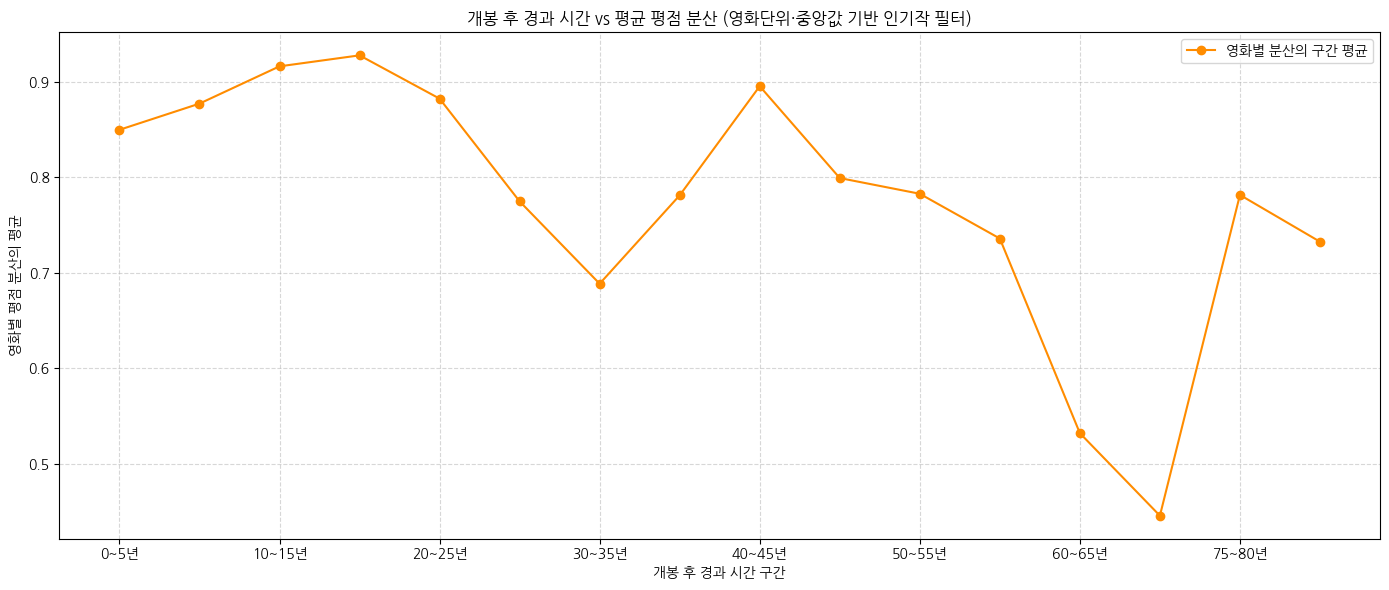

time_bin
0~5년      0.849970
5~10년     0.877428
10~15년    0.916522
15~20년    0.928040
20~25년    0.882653
25~30년    0.774951
30~35년    0.688593
35~40년    0.781263
40~45년    0.895699
45~50년    0.799384
50~55년    0.782905
55~60년    0.735977
60~65년    0.531914
65~70년    0.445355
75~80년    0.781680
80~85년    0.732629
Name: var, dtype: float64


In [ ]:
# 1) 인기작 집합 안에서 영화별 분산
movie_var = (popular.groupby("movieId")["rating"]
                .var()
                .reset_index()
                .rename(columns={"rating":"var"}))

# 2) 영화별 대표 age(평균) 부여
movie_age = (popular.groupby("movieId")["age_at_rating"]
                .mean()
                .reset_index())
movie_var = movie_var.merge(movie_age, on="movieId", how="left")

# 3) 영화 단위로 구간화 → 구간 평균 분산
movie_var["time_bin"] = pd.cut(movie_var["age_at_rating"], bins=bins, right=False, labels=labels)
avg_var_by_bin = (movie_var.groupby("time_bin")["var"]
                    .mean()
                    .dropna())

plt.figure(figsize=(14,6))
avg_var_by_bin.plot(marker="o", color="darkorange", label="영화별 분산의 구간 평균")
plt.title("개봉 후 경과 시간 vs 평균 평점 분산 (영화단위·중앙값 기반 인기작 필터)")
plt.xlabel("개봉 후 경과 시간 구간")
plt.ylabel("영화별 평점 분산의 평균")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(avg_var_by_bin)


### 2차 회귀(OLS)  

In [ ]:
import statsmodels.api as sm

# 영화별 평점 분산 & 평균 경과 시간
movie_var = (popular.groupby("movieId")["rating"]
                .var()
                .reset_index()
                .rename(columns={"rating":"var"}))

movie_age = (popular.groupby("movieId")["age_at_rating"]
                .mean()
                .reset_index())

movie_var = movie_var.merge(movie_age, on="movieId", how="left")

# 결측치 / 음수 제거
movie_var = movie_var.dropna()
movie_var = movie_var[movie_var["age_at_rating"] >= 0]

print(movie_var.head())


   movieId       var  age_at_rating
0        1  0.777089      26.202830
1        2  0.729814      26.184783
2        6  0.544238      26.408602
3       16  0.713766      26.437500
4       32  0.426119      26.222222


In [ ]:
import numpy as np

X_raw = movie_var["age_at_rating"].values
y = movie_var["var"].values

# 2차 다항식 (상수항 + x + x^2)
X = np.column_stack([np.ones_like(X_raw), X_raw, X_raw**2])


In [ ]:
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     9.488
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           8.75e-05
Time:                        01:16:27   Log-Likelihood:                -9.7369
No. Observations:                 617   AIC:                             25.47
Df Residuals:                     614   BIC:                             38.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8834      0.023     38.923      0.0

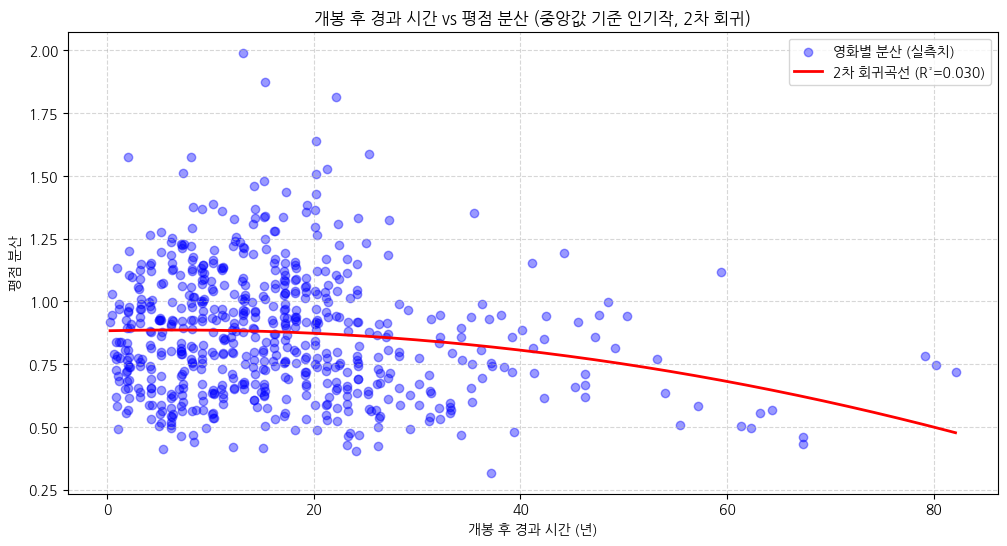

In [ ]:
import matplotlib.pyplot as plt

# 예측용 구간
xg = np.linspace(X_raw.min(), X_raw.max(), 300)
Xg = np.column_stack([np.ones_like(xg), xg, xg**2])
y_pred = ols_model.predict(Xg)

# 시각화
plt.figure(figsize=(12,6))
plt.scatter(X_raw, y, alpha=0.4, label="영화별 분산 (실측치)", color="blue")
plt.plot(xg, y_pred, color="red", linewidth=2,
         label=f"2차 회귀곡선 (R²={ols_model.rsquared:.3f})")

plt.title("개봉 후 경과 시간 vs 평점 분산 (중앙값 기준 인기작, 2차 회귀)")
plt.xlabel("개봉 후 경과 시간 (년)")
plt.ylabel("평점 분산")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
import pandas as pd

# 파일 불러오기
df = pd.read_csv("movies_ratings_post2020.csv")

# 행(row), 열(column) 개수 출력
print("데이터 크기 (행, 열):", df.shape)

# 열 이름 확인
print("\n컬럼 목록:")
print(df.columns.tolist())

# 앞부분 데이터 확인
print("\n데이터 샘플:")
print(df.head())

데이터 크기 (행, 열): (165302, 9)

컬럼 목록:
['userId', 'movieId', 'rating', 'timestamp', 'rating_dt', 'rating_year', 'title', 'genres', 'year']

데이터 샘플:
   userId  movieId  rating   timestamp            rating_dt  rating_year  \
0      22      316     3.0  1614575253  2021-03-01 05:07:33         2021   
1      22      471     4.0  1583618543  2020-03-07 22:02:23         2020   
2      22      551     4.0  1583618449  2020-03-07 22:00:49         2020   
3      22      745     5.0  1668909890  2022-11-20 02:04:50         2022   
4      22     1036     3.5  1674334081  2023-01-21 20:48:01         2023   

                                    title                              genres  \
0                         Stargate (1994)             Action|Adventure|Sci-Fi   
1             Hudsucker Proxy, The (1994)                              Comedy   
2  Nightmare Before Christmas, The (1993)  Animation|Children|Fantasy|Musical   
3  Wallace & Gromit: A Close Shave (1995)           Animation|Children|Come

## 데이터 원본으로 다시 필터링

In [ ]:
import pandas as pd

# 데이터 불러오기
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

print("movies shape:", movies.shape)
print("ratings shape:", ratings.shape)
print("\nmovies 컬럼:", movies.columns.tolist())
print("ratings 컬럼:", ratings.columns.tolist())


movies shape: (87585, 3)
ratings shape: (9594612, 4)

movies 컬럼: ['movieId', 'title', 'genres']
ratings 컬럼: ['userId', 'movieId', 'rating', 'timestamp']


In [ ]:
# title에서 연도 추출
movies["release_year"] = movies["title"].str.extract(r"\((\d{4})\)").astype(float)

# 결측치 처리: 연도 없으면 NaN으로 남김
print(movies[["title","release_year"]].head())


                                title  release_year
0                    Toy Story (1995)        1995.0
1                      Jumanji (1995)        1995.0
2             Grumpier Old Men (1995)        1995.0
3            Waiting to Exhale (1995)        1995.0
4  Father of the Bride Part II (1995)        1995.0


In [ ]:
# timestamp → datetime 변환
ratings["rating_dt"] = pd.to_datetime(ratings["timestamp"], unit="s", errors="coerce")
ratings["rating_year"] = ratings["rating_dt"].dt.year

# 2020-01-01 이후 데이터만 남기기
ratings_2020 = ratings[ratings["rating_dt"] >= "2020-01-01"].copy()
print("원본 ratings:", len(ratings))
print("2020년 이후 ratings:", len(ratings_2020))


원본 ratings: 9594612
2020년 이후 ratings: 1371715


In [ ]:
# ratings_2020과 movies 병합
df = ratings_2020.merge(movies[["movieId","title","genres","release_year"]],
                        on="movieId", how="left")

print(df.head())
print("최종 데이터 크기:", df.shape)


   userId  movieId  rating   timestamp           rating_dt  rating_year  \
0      22      316     3.0  1614575253 2021-03-01 05:07:33         2021   
1      22      471     4.0  1583618543 2020-03-07 22:02:23         2020   
2      22      551     4.0  1583618449 2020-03-07 22:00:49         2020   
3      22      745     5.0  1668909890 2022-11-20 02:04:50         2022   
4      22     1036     3.5  1674334081 2023-01-21 20:48:01         2023   

                                    title                              genres  \
0                         Stargate (1994)             Action|Adventure|Sci-Fi   
1             Hudsucker Proxy, The (1994)                              Comedy   
2  Nightmare Before Christmas, The (1993)  Animation|Children|Fantasy|Musical   
3  Wallace & Gromit: A Close Shave (1995)           Animation|Children|Comedy   
4                         Die Hard (1988)               Action|Crime|Thriller   

   release_year  
0        1994.0  
1        1994.0  
2       

In [ ]:
df["age_at_rating"] = df["rating_year"] - df["release_year"]
df = df[(df["age_at_rating"] >= 0) & df["age_at_rating"].notna()]

print(df[["title","release_year","rating_year","age_at_rating"]].head())


                                    title  release_year  rating_year  \
0                         Stargate (1994)        1994.0         2021   
1             Hudsucker Proxy, The (1994)        1994.0         2020   
2  Nightmare Before Christmas, The (1993)        1993.0         2020   
3  Wallace & Gromit: A Close Shave (1995)        1995.0         2022   
4                         Die Hard (1988)        1988.0         2023   

   age_at_rating  
0           27.0  
1           26.0  
2           27.0  
3           27.0  
4           35.0  


In [ ]:
# df 저장 (CSV)
df.to_csv("movies_ratings_post2020_clean.csv", index=False, encoding="utf-8-sig")

print("저장 완료: movies_ratings_post2020_clean.csv")

저장 완료: movies_ratings_post2020_clean.csv


### 개봉 후 경과 시간에 따른 평점 분산

In [ ]:
# 영화별 평점 분산 계산
movie_var = (df.groupby("movieId")["rating"]
               .var()
               .reset_index()
               .rename(columns={"rating":"var"}))

# 영화별 평균 경과 시간도 계산
movie_age = (df.groupby("movieId")["age_at_rating"]
               .mean()
               .reset_index())

# 병합
movie_stats = movie_var.merge(movie_age, on="movieId", how="left")

print(movie_stats.head())


   movieId       var  age_at_rating
0        1  0.888990      26.111176
1        2  0.789257      26.159317
2        3  1.211885      26.098361
3        4  0.875000      27.166667
4        5  1.377506      26.122807


In [ ]:
import numpy as np

bins = np.arange(0, movie_stats["age_at_rating"].max() + 5, 5)
labels = [f"{int(b)}~{int(b+5)}년" for b in bins[:-1]]
movie_stats["age_bin"] = pd.cut(movie_stats["age_at_rating"], bins=bins, labels=labels, right=False)

# 구간별 평균 분산
age_var = movie_stats.groupby("age_bin")["var"].mean().dropna().reset_index()
print(age_var)


     age_bin       var
0       0~5년  1.058252
1      5~10년  1.048455
2     10~15년  1.028296
3     15~20년  1.025612
4     20~25년  0.993058
5     25~30년  0.928700
6     30~35년  0.946154
7     35~40년  0.962399
8     40~45년  0.915513
9     45~50년  0.976987
10    50~55년  1.025894
11    55~60년  0.975162
12    60~65년  0.839709
13    65~70년  0.915109
14    70~75년  0.836389
15    75~80년  0.879971
16    80~85년  0.889267
17    85~90년  0.690916
18    90~95년  0.797091
19   95~100년  0.674962
20  100~105년  0.626626
21  105~110년  0.712435
22  110~115년  0.865257
23  115~120년  0.991847
24  120~125년  0.903636
25  125~130년  1.175427
26  130~135년  0.477183
27  140~145년  0.125000
28  145~150년  1.500000


/tmp/ipython-input-341719557.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = movie_stats.groupby("age_bin")["var"].mean().dropna().reset_index()


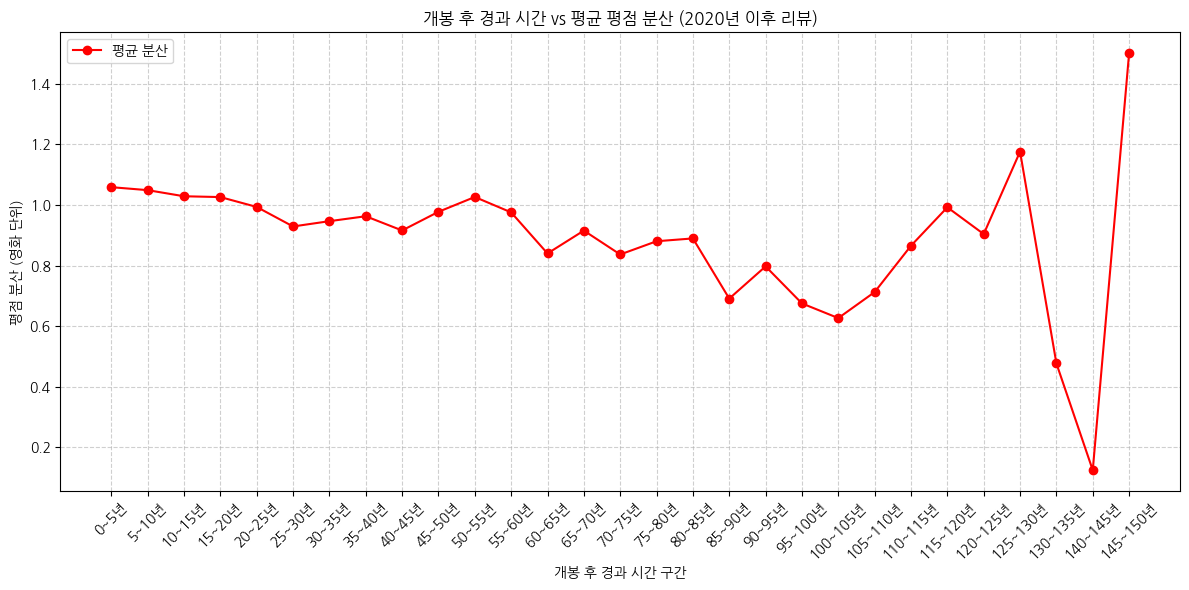

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(age_var["age_bin"], age_var["var"], marker="o", color="red", label="평균 분산")

plt.title("개봉 후 경과 시간 vs 평균 평점 분산 (2020년 이후 리뷰)")
plt.xlabel("개봉 후 경과 시간 구간")
plt.ylabel("평점 분산 (영화 단위)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 행(row), 열(column) 개수 출력
print("데이터 크기 (행, 열):", df.shape)

# 열 이름 확인
print("\n컬럼 목록:")
print(df.columns.tolist())

# 앞부분 데이터 확인
print("\n데이터 샘플:")
print(df.head())

데이터 크기 (행, 열): (1365030, 10)

컬럼 목록:
['userId', 'movieId', 'rating', 'timestamp', 'rating_dt', 'rating_year', 'title', 'genres', 'release_year', 'age_at_rating']

데이터 샘플:
   userId  movieId  rating   timestamp           rating_dt  rating_year  \
0      22      316     3.0  1614575253 2021-03-01 05:07:33         2021   
1      22      471     4.0  1583618543 2020-03-07 22:02:23         2020   
2      22      551     4.0  1583618449 2020-03-07 22:00:49         2020   
3      22      745     5.0  1668909890 2022-11-20 02:04:50         2022   
4      22     1036     3.5  1674334081 2023-01-21 20:48:01         2023   

                                    title                              genres  \
0                         Stargate (1994)             Action|Adventure|Sci-Fi   
1             Hudsucker Proxy, The (1994)                              Comedy   
2  Nightmare Before Christmas, The (1993)  Animation|Children|Fantasy|Musical   
3  Wallace & Gromit: A Close Shave (1995)           An

In [ ]:
target_genres = ["Drama", "Action", "Comedy", "Thriller", "Adventure", "Sci-Fi"]

/tmp/ipython-input-2855564486.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = (movie_stats.groupby("age_bin")["var"]
/tmp/ipython-input-2855564486.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = (movie_stats.groupby("age_bin")["var"]
/tmp/ipython-input-2855564486.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = (movie_stats.groupby("age_bin")["var"]
/tmp/ipython-input-285556448

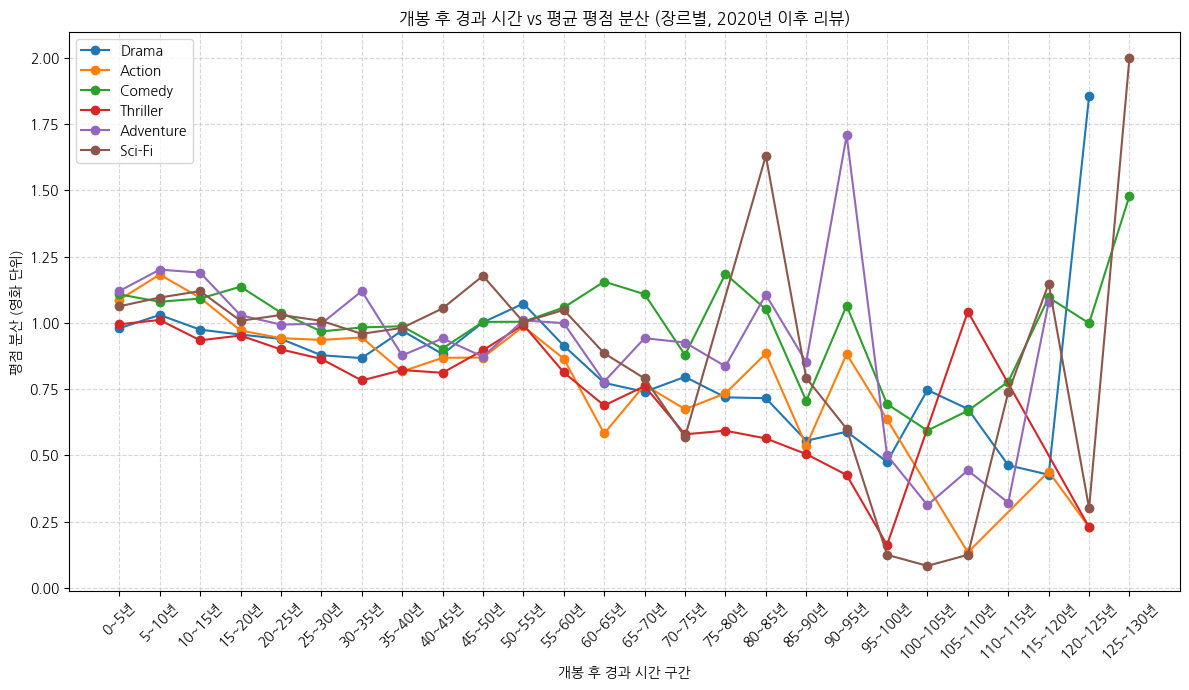

In [ ]:
import numpy as np

# 시각화 준비
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# 각 장르별 반복
for genre in target_genres:
    # 해당 장르 포함된 영화만 추출
    genre_df = df[df["genres"].str.contains(genre, na=False)].copy()

    # 영화별 평점 분산
    movie_var = (genre_df.groupby("movieId")["rating"]
                    .var()
                    .reset_index()
                    .rename(columns={"rating":"var"}))

    # 영화별 평균 age
    movie_age = (genre_df.groupby("movieId")["age_at_rating"]
                    .mean()
                    .reset_index())

    # 병합
    movie_stats = movie_var.merge(movie_age, on="movieId", how="left").dropna()
    movie_stats = movie_stats[movie_stats["age_at_rating"] >= 0]

    # 구간화 (5년 단위)
    bins = np.arange(0, movie_stats["age_at_rating"].max() + 5, 5)
    labels = [f"{int(b)}~{int(b+5)}년" for b in bins[:-1]]
    movie_stats["age_bin"] = pd.cut(movie_stats["age_at_rating"], bins=bins, labels=labels, right=False)

    # 구간별 평균 분산
    age_var = (movie_stats.groupby("age_bin")["var"]
                          .mean()
                          .dropna()
                          .reset_index())

    # 시각화
    plt.plot(age_var["age_bin"], age_var["var"], marker="o", label=genre)

# 그래프 설정
plt.title("개봉 후 경과 시간 vs 평균 평점 분산 (장르별, 2020년 이후 리뷰)")
plt.xlabel("개봉 후 경과 시간 구간")
plt.ylabel("평점 분산 (영화 단위)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
THRESH = 100  # 100년 이상
df_100 = df[df["age_at_rating"] >= THRESH].copy()

print(f"[리뷰 행 수] age_at_rating ≥ {THRESH}: {len(df_100):,}행")
print(f"[영화(고유) 수] age_at_rating ≥ {THRESH}: {df_100['movieId'].nunique():,}편")

[리뷰 행 수] age_at_rating ≥ 100: 1,451행
[영화(고유) 수] age_at_rating ≥ 100: 499편


In [ ]:
cols = {
    "title": ("title","first"),
    "genres": ("genres","first"),
    "release_year": ("release_year","first"),
    "mean_age": ("age_at_rating","mean"),
    "min_rating_year": ("rating_year","min"),
    "max_rating_year": ("rating_year","max"),
    "n_ratings": ("rating","count"),
}
movie_100 = (df_100
             .groupby("movieId")
             .agg(**cols)
             .reset_index()
             .sort_values(["n_ratings","mean_age"], ascending=[False, False]))

print(f"목록(상위 20편):\n{movie_100.head(20)}")

목록(상위 20편):
     movieId                                              title  \
11      6987  Cabinet of Dr. Caligari, The (Cabinet des Dr. ...   
29     32898  Trip to the Moon, A (Voyage dans la lune, Le) ...   
7       3310                                    Kid, The (1921)   
0       1348  Nosferatu (Nosferatu, eine Symphonie des Graue...   
13      7065                      Birth of a Nation, The (1915)   
33     49389                     The Great Train Robbery (1903)   
15      7243  Intolerance: Love's Struggle Throughout the Ag...   
6       3309                               Dog's Life, A (1918)   
61     82848                                    One Week (1920)   
27     25744  Haxan: Witchcraft Through the Ages (a.k.a. The...   
18      8511                              Immigrant, The (1917)   
24     25741           Phantom Carriage, The (Körkarlen) (1921)   
92     98981                     Arrival of a Train, The (1896)   
12      6988  Broken Blossoms or The Yellow Man an

In [ ]:
MIN_REV = 20   # 필요시 5/10/50 등으로 조절
movie_100_min = movie_100[movie_100["n_ratings"] >= MIN_REV].copy()

print(f"\n[리뷰 {MIN_REV}개 이상] 영화 수: {len(movie_100_min):,}편")
print(movie_100_min.head(20))


[리뷰 20개 이상] 영화 수: 6편
    movieId                                              title  \
11     6987  Cabinet of Dr. Caligari, The (Cabinet des Dr. ...   
29    32898  Trip to the Moon, A (Voyage dans la lune, Le) ...   
7      3310                                    Kid, The (1921)   
0      1348  Nosferatu (Nosferatu, eine Symphonie des Graue...   
13     7065                      Birth of a Nation, The (1915)   
33    49389                     The Great Train Robbery (1903)   

                             genres  release_year    mean_age  \
11             Crime|Fantasy|Horror        1920.0  101.353448   
29  Action|Adventure|Fantasy|Sci-Fi        1902.0  119.303371   
7                      Comedy|Drama        1921.0  100.714286   
0                            Horror        1922.0  100.416667   
13                        Drama|War        1915.0  106.440000   
33                    Crime|Western        1903.0  118.260870   

    min_rating_year  max_rating_year  n_ratings  
11       

### 중앙값 기준 필터링

In [ ]:
import numpy as np

# 영화별 리뷰 수 집계
movie_counts = df.groupby("movieId")["rating"].count().reset_index().rename(columns={"rating":"n_ratings"})

# 중앙값 계산
median_reviews = movie_counts["n_ratings"].median()
print("리뷰 수 중앙값:", median_reviews)

# 상위 50% 영화만 남김
popular_movies = movie_counts[movie_counts["n_ratings"] >= median_reviews]
df_popular = df.merge(popular_movies[["movieId"]], on="movieId", how="inner")

print("필터링 후 리뷰 수:", len(df_popular))
print("필터링 후 영화 수:", df_popular['movieId'].nunique())


리뷰 수 중앙값: 2.0
필터링 후 리뷰 수: 1347255
필터링 후 영화 수: 27115


많은 영화들이 리뷰를 거의 안 받았고, 영화 수는 많지만 리뷰가 1~2개밖에 없는 작품이 절반 이상이라는 상황이 관측됨.

-> 실제로 이런 분포는 보통 power law / Zipf’s law처럼,
컨텐츠 플랫폼(왓챠, 넷플릭스, 스팀 등)에서 "대부분의 작품은 소수만 소비하고, 소수의 인기작이 다수의 리뷰를 독점"하는 구조 때문

중앙값의 분포가 극단적으로 치우쳐있기 때문에, 의미가 없는 기준이라고 판단함.

상위 75% (3사분위수) 이상, 리뷰 수가 상위 25%에 속하는 영화만 분석해 리뷰 수가 분석 가능한 정도인 데이터만 뽑아내기로 결정

In [ ]:
# 리뷰 수 분위수 기준 계산
q75 = movie_counts["n_ratings"].quantile(0.75)
q90 = movie_counts["n_ratings"].quantile(0.90)

print("리뷰 수 75% 분위수:", q75)
print("리뷰 수 90% 분위수:", q90)

# 75% 이상 영화만 남기기
popular_75 = movie_counts[movie_counts["n_ratings"] >= q75]
df_popular_75 = df.merge(popular_75[["movieId"]], on="movieId", how="inner")

# 90% 이상 영화만 남기기
popular_90 = movie_counts[movie_counts["n_ratings"] >= q90]
df_popular_90 = df.merge(popular_90[["movieId"]], on="movieId", how="inner")

print("필터링 후 영화 수 (상위 25%):", df_popular_75["movieId"].nunique())
print("필터링 후 영화 수 (상위 10%):", df_popular_90["movieId"].nunique())

리뷰 수 75% 분위수: 7.0
리뷰 수 90% 분위수: 37.0
필터링 후 영화 수 (상위 25%): 11851
필터링 후 영화 수 (상위 10%): 4522


### 75%, 90%

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 영화별 리뷰 수 집계
movie_counts = (df.groupby("movieId")["rating"]
                  .count()
                  .reset_index()
                  .rename(columns={"rating":"n_ratings"}))

# 분위수 계산 (원하는 값으로 바꾸세요: 0.75 또는 0.90 등)
q75 = movie_counts["n_ratings"].quantile(0.75)
q90 = movie_counts["n_ratings"].quantile(0.90)
print("리뷰 수 75% 분위수:", int(q75))
print("리뷰 수 90% 분위수:", int(q90))


리뷰 수 75% 분위수: 7
리뷰 수 90% 분위수: 37


In [ ]:
def plot_overall_by_percentile(df, movie_counts, percentile=0.75, bin_years=5, title_suffix="(상위 25%)"):
    # 1) 필터링
    thr = movie_counts["n_ratings"].quantile(percentile)
    popular_ids = movie_counts.loc[movie_counts["n_ratings"] >= thr, "movieId"]
    dfp = df[df["movieId"].isin(popular_ids)].copy()

    print(f"[{percentile:.2f} 분위수 기준] 임계값={int(thr)}, 리뷰 행={len(dfp):,}, 영화 수={dfp['movieId'].nunique():,}")

    # 2) 영화 단위 분산 & 대표 age(평균) 계산
    mv = (dfp.groupby("movieId")["rating"].var().reset_index().rename(columns={"rating":"var"}))
    ages = (dfp.groupby("movieId")["age_at_rating"].mean().reset_index())
    mv = mv.merge(ages, on="movieId", how="left").dropna()
    mv = mv[mv["age_at_rating"] >= 0]

    # 3) 구간화
    if mv.empty:
        print("필터 결과가 비었습니다. 퍼센타일을 낮추거나 데이터 확인이 필요합니다.")
        return
    bins = np.arange(0, mv["age_at_rating"].max() + bin_years, bin_years)
    if len(bins) < 2:  # 안전장치
        bins = np.array([0, bin_years])
    mv["age_bin"] = pd.cut(mv["age_at_rating"], bins=bins)

    # 4) 구간 평균 분산
    age_var = mv.groupby("age_bin")["var"].mean().reset_index()

    # 5) 시각화
    plt.figure(figsize=(12,6))
    plt.plot(age_var["age_bin"].astype(str), age_var["var"], marker="o", color="red", label="평균 분산")
    plt.xticks(rotation=45)
    plt.title(f"개봉 후 경과 시간 vs 평균 평점 분산 {title_suffix}")
    plt.xlabel("개봉 후 경과 시간 구간 (년)")
    plt.ylabel("평점 분산 (영화 단위)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_by_genre_percentile(
    df, movie_counts, percentile=0.75, target_genres=None, bin_years=5, ncols=3, suptitle_suffix="(상위 25%)"
):
    if target_genres is None:
        target_genres = ["Drama","Action","Comedy","Thriller","Adventure","Sci-Fi"]

    thr = movie_counts["n_ratings"].quantile(percentile)
    popular_ids = movie_counts.loc[movie_counts["n_ratings"] >= thr, "movieId"]
    dfp = df[df["movieId"].isin(popular_ids)].copy()

    print(f"[장르별] {percentile:.2f} 분위수 기준 임계값={int(thr)}, 리뷰 행={len(dfp):,}, 영화 수={dfp['movieId'].nunique():,}")

    n = len(target_genres)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows), sharey=True)
    axes = np.array(axes).reshape(-1)  # 2D → 1D

    for i, g in enumerate(target_genres):
        ax = axes[i]
        sub = dfp[dfp["genres"].str.contains(g, na=False)].copy()
        if sub.empty:
            ax.set_title(f"{g} (데이터 없음)")
            ax.axis("off")
            continue

        # 영화 단위 분산 & 대표 age
        mv = (sub.groupby("movieId")["rating"].var().reset_index().rename(columns={"rating":"var"}))
        ages = (sub.groupby("movieId")["age_at_rating"].mean().reset_index())
        mv = mv.merge(ages, on="movieId", how="left").dropna()
        mv = mv[mv["age_at_rating"] >= 0]

        if mv.empty:
            ax.set_title(f"{g} (영화 없음)")
            ax.axis("off")
            continue

        bins = np.arange(0, mv["age_at_rating"].max() + bin_years, bin_years)
        if len(bins) < 2:
            bins = np.array([0, bin_years])
        mv["age_bin"] = pd.cut(mv["age_at_rating"], bins=bins)

        age_var = mv.groupby("age_bin")["var"].mean().reset_index()

        ax.plot(age_var["age_bin"].astype(str), age_var["var"], marker="o")
        ax.set_title(g)
        ax.set_xlabel("경과 시간 (년)")
        ax.set_ylabel("평점 분산")
        ax.tick_params(axis="x", rotation=45)
        ax.grid(True, linestyle="--", alpha=0.5)

    # 남는 서브플롯 비활성화
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"장르별: 개봉 후 경과 시간 vs 평균 평점 분산 {suptitle_suffix}", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


[0.75 분위수 기준] 임계값=7, 리뷰 행=1,299,229, 영화 수=11,851


/tmp/ipython-input-1585253178.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = mv.groupby("age_bin")["var"].mean().reset_index()


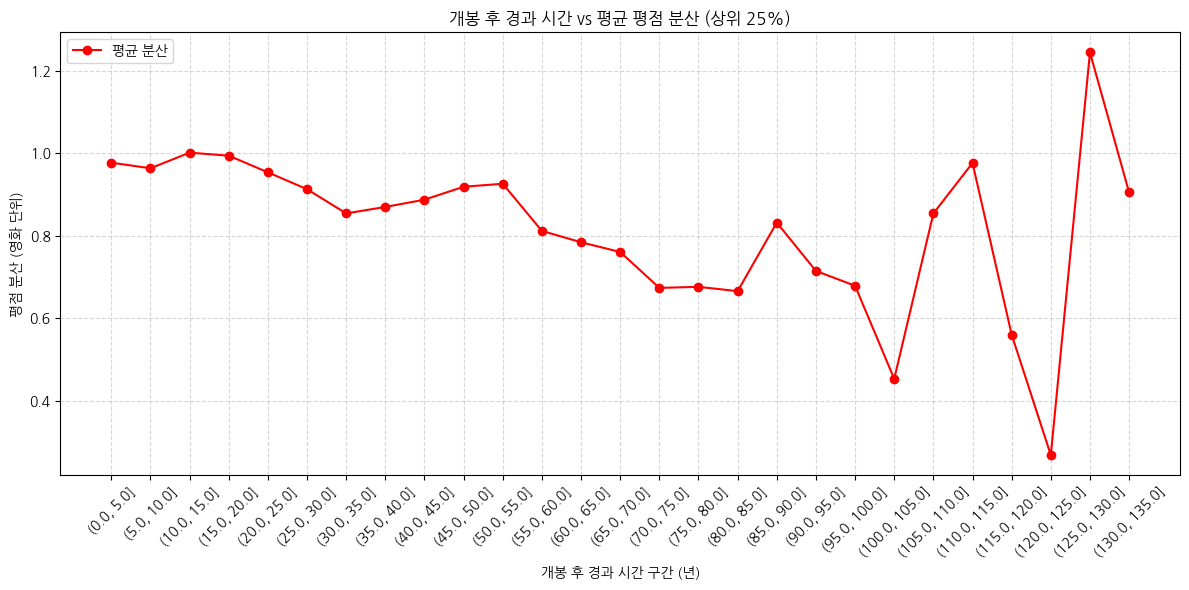

[0.90 분위수 기준] 임계값=37, 리뷰 행=1,187,403, 영화 수=4,522


/tmp/ipython-input-1585253178.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = mv.groupby("age_bin")["var"].mean().reset_index()


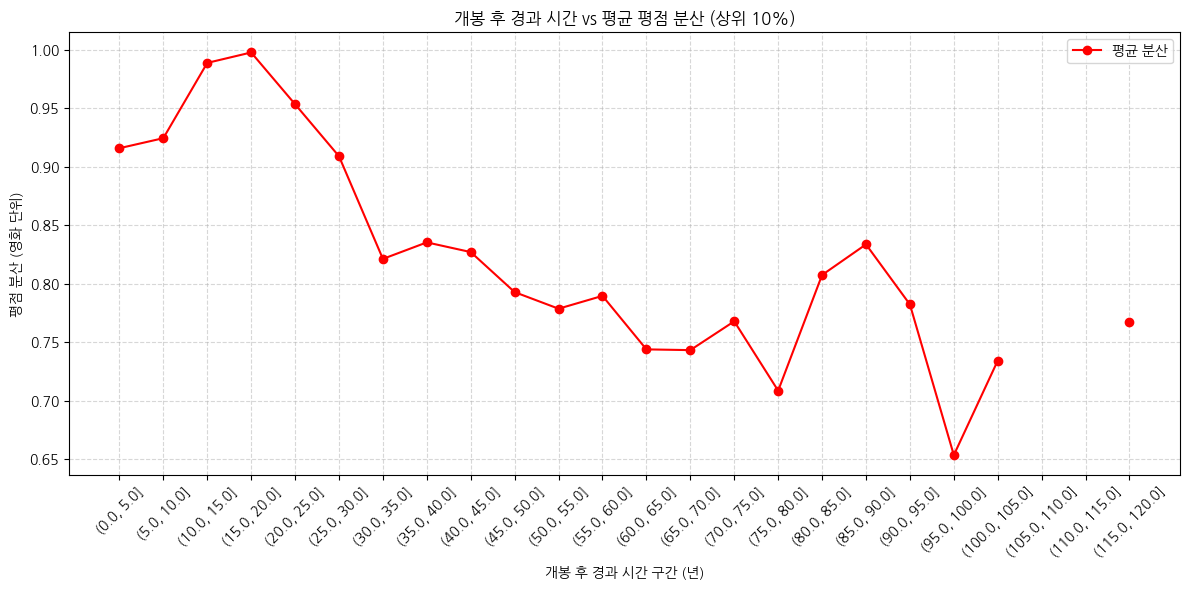

In [ ]:
# 리뷰 수 상위 25% (75 분위수 이상 영화만 포함)
plot_overall_by_percentile(df, movie_counts, percentile=0.75, title_suffix="(상위 25%)")

# 리뷰 수 상위 10% (90 분위수 이상 영화만 포함)
plot_overall_by_percentile(df, movie_counts, percentile=0.90, title_suffix="(상위 10%)")


[장르별] 0.75 분위수 기준 임계값=7, 리뷰 행=1,299,229, 영화 수=11,851


/tmp/ipython-input-402504217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = mv.groupby("age_bin")["var"].mean().reset_index()
/tmp/ipython-input-402504217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = mv.groupby("age_bin")["var"].mean().reset_index()
/tmp/ipython-input-402504217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = mv.groupby("age_bin")["var"].mean().reset_index(

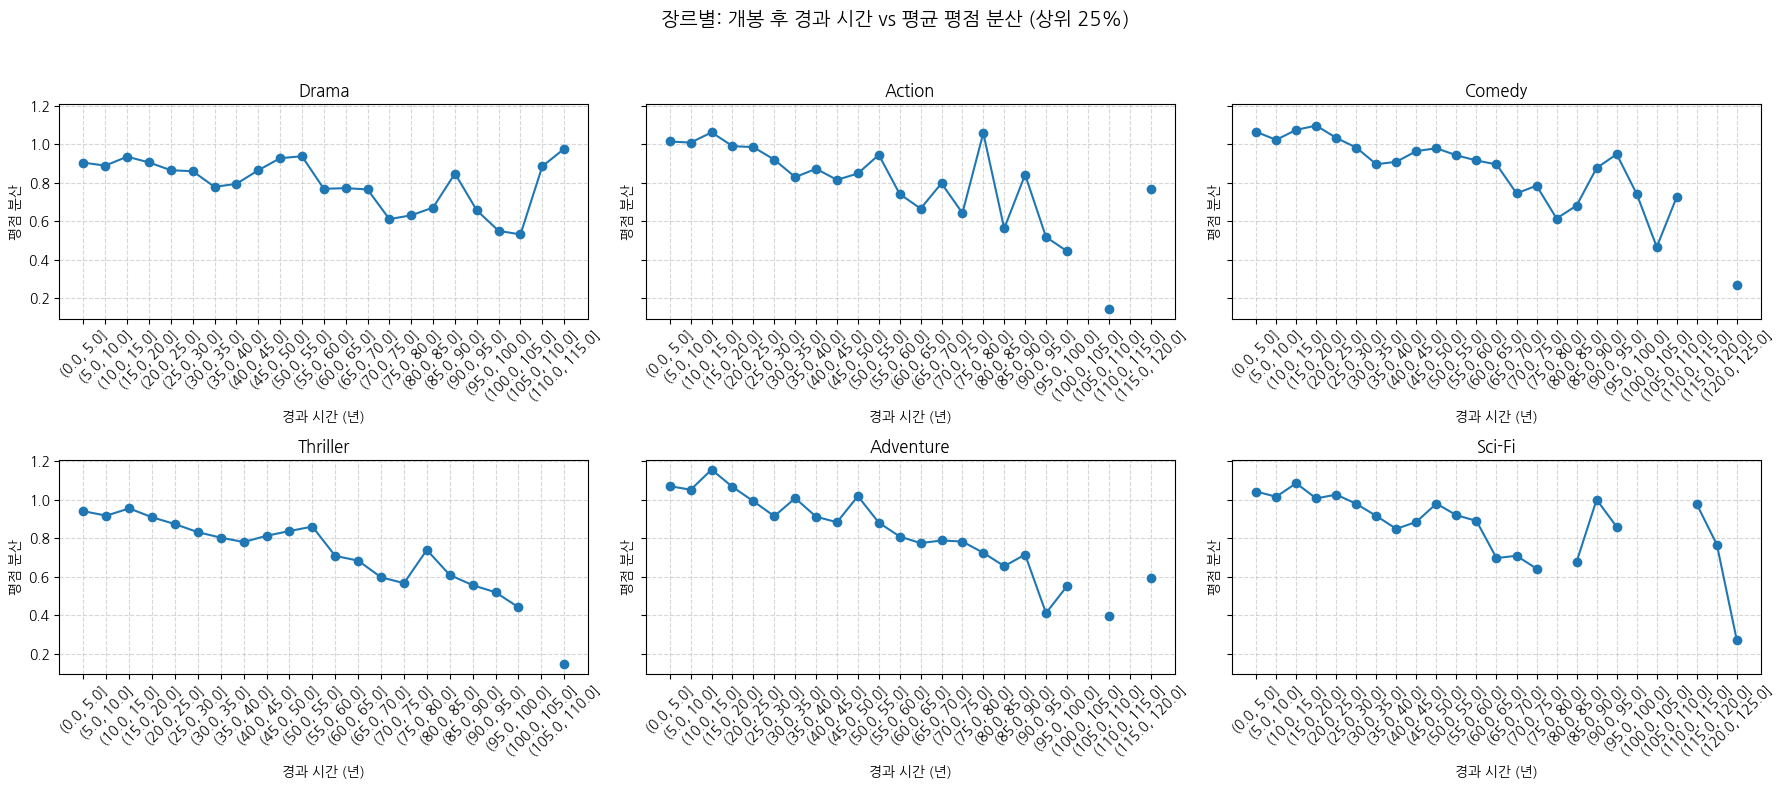

[장르별] 0.90 분위수 기준 임계값=37, 리뷰 행=1,187,403, 영화 수=4,522


/tmp/ipython-input-402504217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = mv.groupby("age_bin")["var"].mean().reset_index()
/tmp/ipython-input-402504217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = mv.groupby("age_bin")["var"].mean().reset_index()
/tmp/ipython-input-402504217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_var = mv.groupby("age_bin")["var"].mean().reset_index(

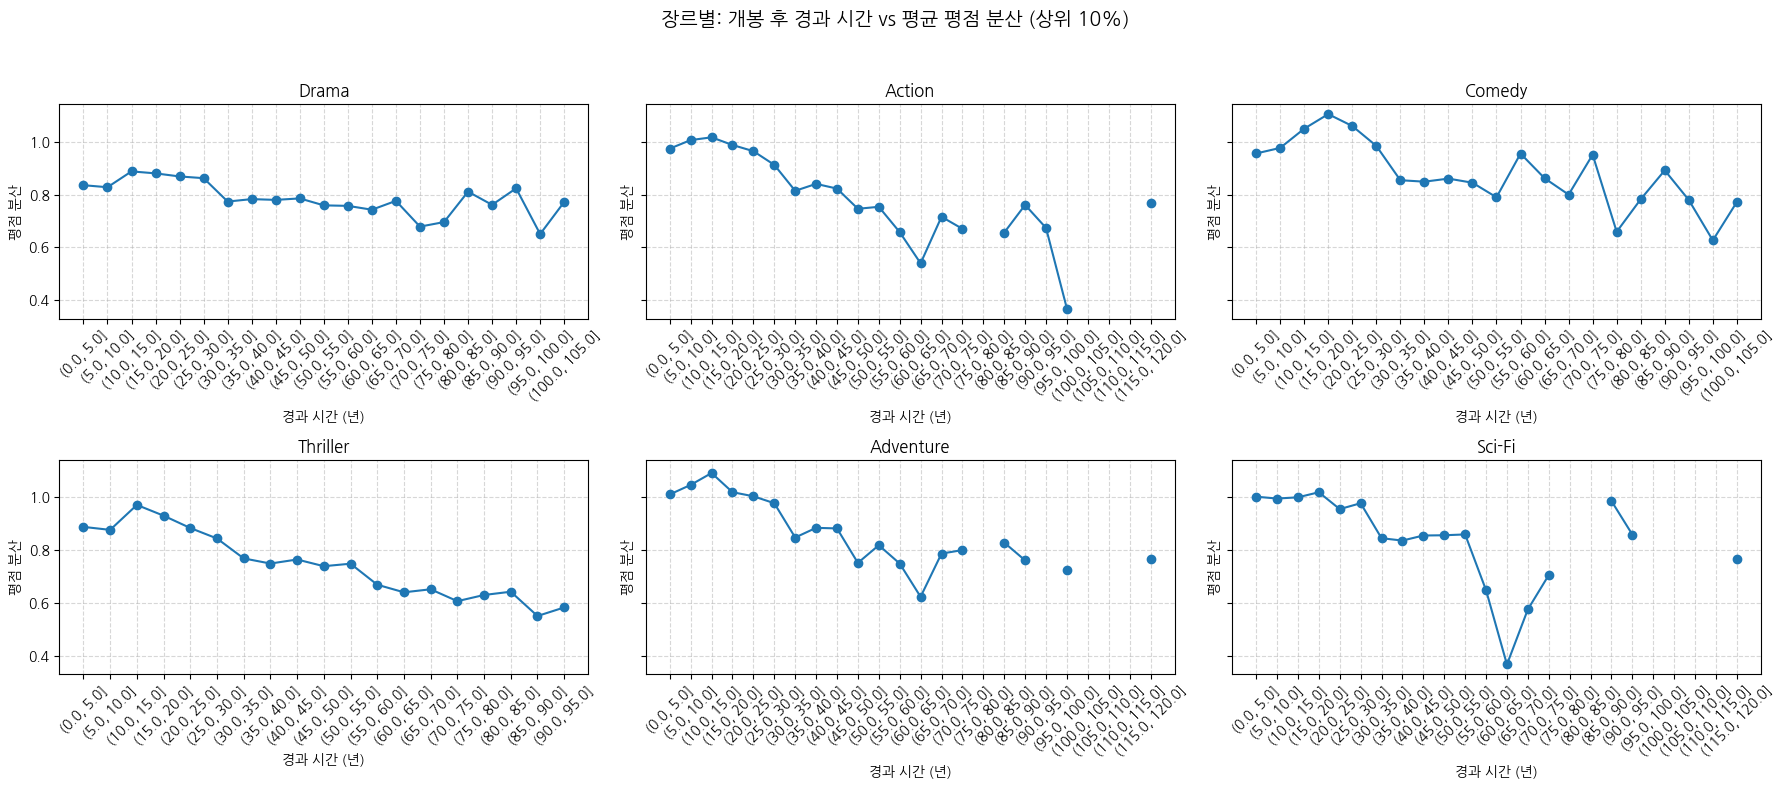

In [ ]:
target_genres = ["Drama","Action","Comedy","Thriller","Adventure","Sci-Fi"]

# 상위 25%
plot_by_genre_percentile(df, movie_counts, percentile=0.75,
                         target_genres=target_genres,
                         suptitle_suffix="(상위 25%)")

# 상위 10%
plot_by_genre_percentile(df, movie_counts, percentile=0.90,
                         target_genres=target_genres,
                         suptitle_suffix="(상위 10%)")


In [ ]:
import pandas as pd

# 1. movies.csv 불러오기
movies = pd.read_csv("movies.csv")
print("🎬 movies.csv 데이터 정보")
print("행(row) 수:", movies.shape[0])
print("열(column) 수:", movies.shape[1])
print("\n컬럼명:", movies.columns.tolist())
print("\n앞 5행:")
print(movies.head(), "\n")

# 2. ratings.csv 불러오기
ratings = pd.read_csv("ratings.csv")
print("⭐ ratings.csv 데이터 정보")
print("행(row) 수:", ratings.shape[0])
print("열(column) 수:", ratings.shape[1])
print("\n컬럼명:", ratings.columns.tolist())
print("\n앞 5행:")
print(ratings.head(), "\n")

🎬 movies.csv 데이터 정보
행(row) 수: 87585
열(column) 수: 3

컬럼명: ['movieId', 'title', 'genres']

앞 5행:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

⭐ ratings.csv 데이터 정보
행(row) 수: 32000204
열(column) 수: 4

컬럼명: ['userId', 'movieId', 'rating', 'timestamp']

앞 5행:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4    

In [ ]:
import pandas as pd

# 1. movies.csv 불러오기
movies = pd.read_csv("movies.csv")
print("🎬 movies.csv 데이터 정보")
print("행(row) 수:", movies.shape[0])
print("열(column) 수:", movies.shape[1])
print("\n컬럼명:", movies.columns.tolist())

print("\n앞 5행:")
print(movies.head())

print("\n세부 info():")
print(movies.info())
print("="*80)

# 2. ratings.csv 불러오기
ratings = pd.read_csv("ratings.csv")
print("⭐ ratings.csv 데이터 정보")
print("행(row) 수:", ratings.shape[0])
print("열(column) 수:", ratings.shape[1])
print("\n컬럼명:", ratings.columns.tolist())

print("\n앞 5행:")
print(ratings.head())

print("\n세부 info():")
print(ratings.info())

🎬 movies.csv 데이터 정보
행(row) 수: 87585
열(column) 수: 3

컬럼명: ['movieId', 'title', 'genres']

앞 5행:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

세부 info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtype